# 1. Подготовка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics.scorer import make_scorer

## 1.1. Подготовка файлов

In [3]:
data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
data_valid = pd.read_csv('/datasets/gold_recovery_test.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [4]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [5]:
print(data_valid.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [6]:
print(data_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

## 1.2. Проверка расчета эффективности обогащения

In [7]:
def recovery(data):
    C = data['rougher.output.concentrate_au']
    F = data['rougher.input.feed_au']
    T = data['rougher.output.tail_au']
    au_share_after_flotation = C * (F - T)
    au_share_before_flotation = F * (C - T)
    R = (au_share_after_flotation / au_share_before_flotation) * 100
    return R

In [8]:
#отбор нужных данных
data_recovery_check = data_train[['rougher.output.concentrate_au',
                                'rougher.input.feed_au',
                                'rougher.output.tail_au',
                                'rougher.output.recovery']]
#расчет recovery
data_recovery_check['recovery_calc'] = data_recovery_check.apply(lambda x: recovery(x), axis=1)
#средняя абсолютная ошибка
mae = round((data_recovery_check['recovery_calc'] - data_recovery_check['rougher.output.recovery']).mean(), 12)
print(mae)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


-0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


**Вывод.** Средняя абсолютная ошибка равна нулю в округлении до 12 знаков. Значит, в исходных данных эффективность обогащения рассчитана верно.

## 1.3. Анализ параметров, недоступных в тестовой выборке

In [9]:
columns_train = data_train.columns
columns_valid = data_valid.columns
columns_empty = []
for column in columns_train:
    if column not in columns_valid:
        print(column)
        columns_empty.append(column)
        
print()
print('Всего отсутствующих признаков:', len(columns_empty))

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

Из отсутствующих в валидации признаков:
- 9 относятся к финальному этапу, где получается финальный концентрат;
- 8 относятся к результату первичной очистки;
- 4 признака - расчетные параметры флотации (соотношение элементов в продукте);
- ещё 5 - результат флотации;
- и, наконец, 4 признака - результат вторичной очистки.

Все признаки характеризуют продукт, получаемый на различных этапах производства.

## 1.4. Предобработка данных

In [10]:
#посмотрим на данные
display(data_train.head())
display(data_valid.head())
display(data_full.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Во всех трех датафреймах признаки имеют численный вид формата float. Учитывая особенности техпроцесса, пропуски можно заполнять предыдущим значением. Что необходимо сделать для предобработки:
- преобразовать дату в формат даты;
- заполнить NaN (будем заполнять предыдущими значениями).

In [11]:
for dataframe in (data_train, data_valid, data_full):
    dataframe['date'] = pd.to_datetime(dataframe['date'], format='%Y-%m-%d %H:%M:%S')
    dataframe.ffill(inplace=True)
    dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null datetime64[ns]
final.output.concentrate_ag                           16860 non-null float64
final.output.concentrate_pb                           16860 non-null float64
final.output.concentrate_sol                          16860 non-null float64
final.output.concentrate_au                           16860 non-null float64
final.output.recovery                                 16860 non-null float64
final.output.tail_ag                                  16860 non-null float64
final.output.tail_pb                                  16860 non-null float64
final.output.tail_sol                                 16860 non-null float64
final.output.tail_au                                  16860 non-null float64
primary_cleaner.input.sulfate                         16860 non-null float64
primary_cleaner.input.depressant     

# 2. Анализ данных

## 2.1. Анализ изменения концентрации веществ на различных этапах.

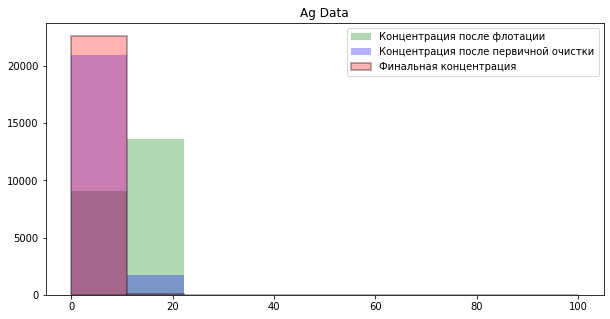

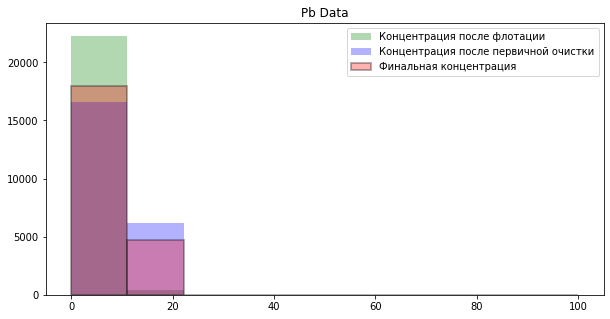

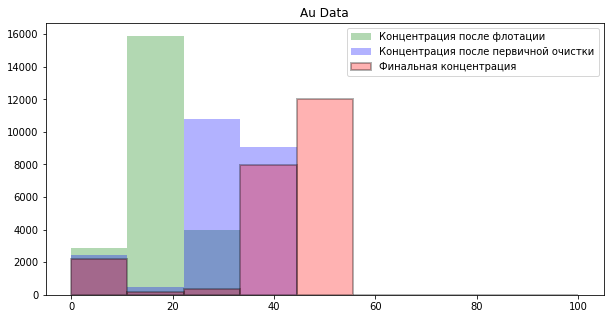

In [12]:
%matplotlib inline
#данные по Ag
ag_data = data_full[['rougher.output.concentrate_ag',
                    'primary_cleaner.output.concentrate_ag',
                    'final.output.concentrate_ag']]
ag_data.name = 'Ag Data'
#по Pb
pb_data = data_full[['rougher.output.concentrate_pb',
                    'primary_cleaner.output.concentrate_pb',
                    'final.output.concentrate_pb']]
pb_data.name = 'Pb Data'
#по Au
au_data = data_full[['rougher.output.concentrate_au',
                    'primary_cleaner.output.concentrate_au',
                    'final.output.concentrate_au']]
au_data.name = 'Au Data'
bins = np.linspace(0, 100, 10)

#построение графиков
for data in [ag_data, pb_data, au_data]:
    rougher_output_concentrate = data.iloc[:, 0]
    primary_cleaner_output_concentrate = data.iloc[:, 1]
    final_output_concentrate = data.iloc[:, 2]
    plt.figure(figsize=(10, 5))
    plt.hist(rougher_output_concentrate,
             bins,
             alpha=0.3,
             color='green',
             label='Концентрация после флотации')
    plt.hist(primary_cleaner_output_concentrate,
             bins,
             alpha=0.3,
             color='blue',
             label='Концентрация после первичной очистки')
    plt.hist(final_output_concentrate,
             bins,
             alpha=0.3,
             color='red',
             edgecolor='black',
             linewidth=2,
             label='Финальная концентрация')
    plt.legend(loc='upper right')
    plt.title((data.name))
    plt.show()

**Выводы.**<br>
1) В случае с серебром (Ag) его концентрация максимальна после флотации и в дальнейшем уменьшается с каждым этапом очистки.<br>
2) Концентрация свинца (Pb) в процессе очистки остается практически неизменной.<br>
3) Концентрация золота (Au) после флотации составляет в среднем около 15-20% и в процессе очистки увеличивается до 40-50%.

## 2.2. Анализ распределения размеров гранул

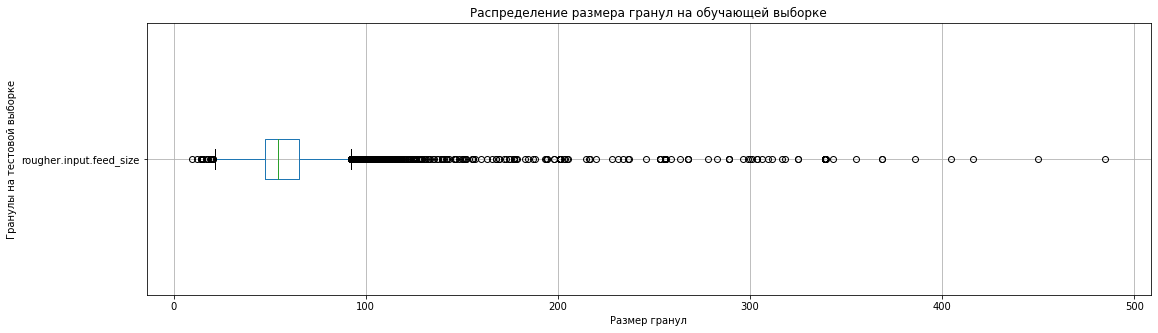

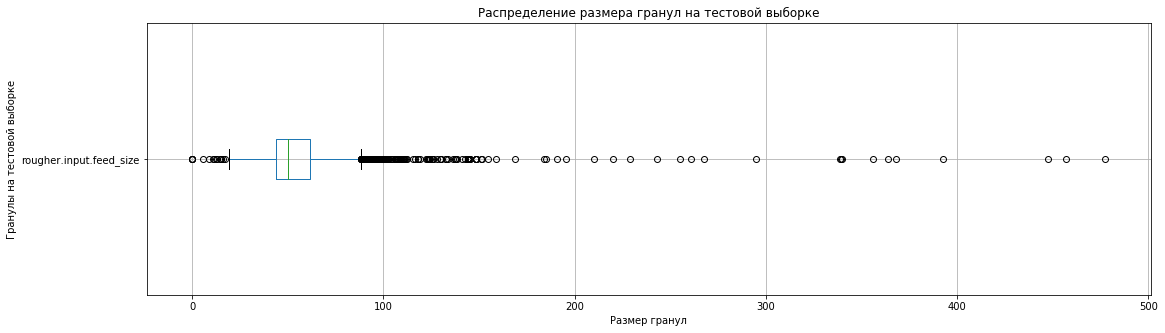

In [13]:
grain_size_train = data_train['rougher.input.feed_size']
grain_size_valid = data_valid['rougher.input.feed_size']

#строим ящики с усами
(pd.DataFrame(grain_size_train).boxplot(figsize=(18, 5),
                                        vert=False)
    .set(title='Распределение размера гранул на обучающей выборке',
        xlabel='Размер гранул',
        ylabel='Гранулы на тестовой выборке'))
plt.show()

(pd.DataFrame(grain_size_valid).boxplot(figsize=(18, 5),
                                        vert=False)
    .set(title='Распределение размера гранул на тестовой выборке',
        xlabel='Размер гранул',
        ylabel='Гранулы на тестовой выборке'))
plt.show()

In [14]:
print('Описание размеров гранул на обучающей выборке')
print(grain_size_train.describe())
print()
print('Описание размеров гранул на тестовой выборке')
print(grain_size_valid.describe())

Описание размеров гранул на обучающей выборке
count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Описание размеров гранул на тестовой выборке
count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64


**Вывод.**<br>
Большая часть размеров гранул лежит в диапазоне от 0 до 300. В обеих выборках есть выбросы более 350, однако в целом распределения примерно одинаковые.

## 2.3. Исследование суммарных концентраций.

In [15]:
#суммирование концентраций в отдельном датафрейме
data_concentration = pd.DataFrame()
data_full['rougher.output.concentrate_total'] = (data_full['rougher.input.feed_ag'] +
                                                 data_full['rougher.output.concentrate_ag'] + 
                                                 data_full['rougher.output.concentrate_pb'] +
                                                 data_full['rougher.output.concentrate_au']
                                                          )
data_full['primary_cleaner.output.concentrate_total'] = (data_full['rougher.input.feed_ag'] +
                                                         data_full['primary_cleaner.output.concentrate_ag'] +
                                                         data_full['primary_cleaner.output.concentrate_pb'] +
                                                         data_full['primary_cleaner.output.concentrate_au']
                                                                 )
data_full['final.output.concentrate_total'] = (data_full['rougher.input.feed_ag'] +
                                               data_full['final.output.concentrate_ag'] +
                                               data_full['final.output.concentrate_pb'] +
                                               data_full['final.output.concentrate_au']
                                                       )

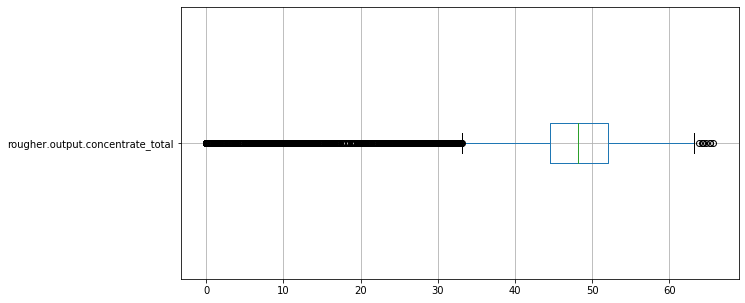

count    22716.000000
mean        43.608225
std         15.731183
min          0.000000
25%         44.496375
50%         48.113327
75%         52.080757
max         65.688715
Name: rougher.output.concentrate_total, dtype: float64


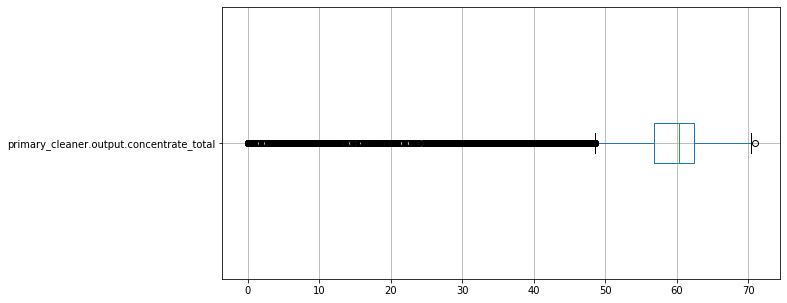

count    22716.000000
mean        53.640393
std         18.413270
min          0.000000
25%         56.907187
50%         60.299666
75%         62.433472
max         70.989495
Name: primary_cleaner.output.concentrate_total, dtype: float64


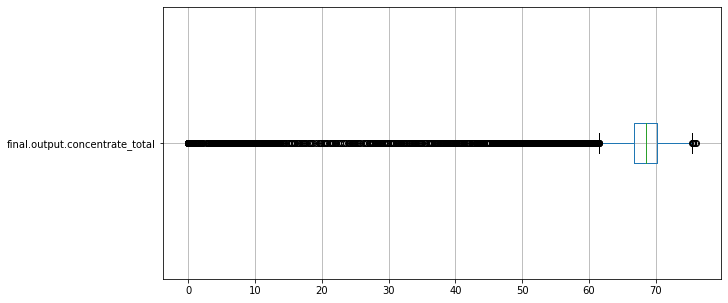

count    22716.000000
mean        61.775334
std         20.201388
min          0.000000
25%         66.730894
50%         68.599700
75%         70.227699
max         75.993247
Name: final.output.concentrate_total, dtype: float64


In [16]:
#построение распределений
for column in ['rougher.output.concentrate_total',
              'primary_cleaner.output.concentrate_total',
              'final.output.concentrate_total']:
    data_full.boxplot(column, figsize=(10, 5), vert=False)
    plt.show()
    print(data_full[column].describe())

In [17]:
#расчет доли нулевых значений от общего
for column in ['rougher.output.concentrate_total',
              'primary_cleaner.output.concentrate_total',
              'final.output.concentrate_total']:
    zeros_count = data_full[data_full[column] == 0][column].count()
    zeros_share = zeros_count / data_full[column].count()
    print(column)
    print(zeros_count)
    print(zeros_share)
    print()

rougher.output.concentrate_total
1519
0.06686916710688502

primary_cleaner.output.concentrate_total
1447
0.06369959499911956

final.output.concentrate_total
1384
0.060926219404824795



In [18]:
#по идее при обогащении руды концентрация металлов должна увеличиваться с каждым этапом. Проверим.
data_rougher_bigger = data_full.loc[data_full['rougher.output.concentrate_total'] > 
                                    data_full['primary_cleaner.output.concentrate_total']]
data_primary_cleaner_bigger = data_full.loc[data_full['primary_cleaner.output.concentrate_total'] >
                                            data_full['final.output.concentrate_total']]
print(data_rougher_bigger['rougher.output.concentrate_total'].count())
print()
print(data_primary_cleaner_bigger['final.output.concentrate_total'].count())

1143

737


**Вывод.** В данных присутствуют аномалии:<br>
1) На всех трех этапах есть общая концентрация 0. Такого не может быть, иначе весь процесс не имеет смысла. Также очень много околонулевых значений.<br>
2) На этапе флотации есть концентрации более 65%. При этом среднее значение 43.7, медиана - 48.<br>
3) Есть строки, в которых на последующем этапе концентрация ниже, чем на предыдущем. По идее такого быть не должно. Возможно, это обусловлено технологией процесса (например, в руду добавляют какие-то реактивы, котоыре снижают концентрацию). Однако в таком случае подобных записей слишком мало (от 500 до 1000 на 22000+ записей). По-хорошему следует задать вопрос технологам, в данном случае будем считать это аномалией.

<u>Итого:</u> убираем значения меньше 10, на флотации отсекаем значения более 65%, убираем строки по убыванию концентрации.

In [19]:
#убираем нули
columns = ['rougher.output.concentrate_total',
           'primary_cleaner.output.concentrate_total',
           'final.output.concentrate_total']
for column in columns:
    data_full = data_full.loc[data_full[column] >= 10]
#data_full = data_full.loc[dat.dropna(subset=columns)

In [20]:
#отсекаем более 65% на выходе после флотации
data_full = data_full[data_full['rougher.output.concentrate_total'] <= 65]

In [21]:
#убираем записи, где концентрация после первичной очистки меньше, чем после флотации
#и те, где финальная концентрация меньше, чем после первичной очистки

data_full = data_full.loc[(data_full['rougher.output.concentrate_total'] <= 
                          data_full['primary_cleaner.output.concentrate_total']) &
                         (data_full['primary_cleaner.output.concentrate_total'] <=
                                            data_full['final.output.concentrate_total'])]

In [22]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18730 entries, 0 to 22715
Data columns (total 90 columns):
date                                                  18730 non-null datetime64[ns]
final.output.concentrate_ag                           18730 non-null float64
final.output.concentrate_pb                           18730 non-null float64
final.output.concentrate_sol                          18730 non-null float64
final.output.concentrate_au                           18730 non-null float64
final.output.recovery                                 18730 non-null float64
final.output.tail_ag                                  18730 non-null float64
final.output.tail_pb                                  18730 non-null float64
final.output.tail_sol                                 18730 non-null float64
final.output.tail_au                                  18730 non-null float64
primary_cleaner.input.sulfate                         18730 non-null float64
primary_cleaner.input.depressant     

Итого после обработки данных получаем 20752 записи.

# 3. Модель

In [23]:
def smape(target, predicted):
    a = target[{'rougher.output.recovery','final.output.recovery'}]
    f = predicted[{'rougher.output.recovery','final.output.recovery'}]
    pre_smape = 100/len(a) * np.sum(2 * np.abs(a-f) / (np.abs(a) + np.abs(f)))
    return 0.25 * pre_smape['rougher.output.recovery'] + 0.75 * pre_smape['final.output.recovery']
    print(a)

In [24]:
#отделение признаков, которых нет на валидации
data_train_cut = data_train.drop('date', axis=1)
for column in columns_empty:
    data_train_cut = data_train_cut.drop(column, axis=1)

In [25]:
data_train_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 16860 non-null float64
primary_cleaner.input.depressant              16860 non-null float64
primary_cleaner.input.feed_size               16860 non-null float64
primary_cleaner.input.xanthate                16860 non-null float64
primary_cleaner.state.floatbank8_a_air        16860 non-null float64
primary_cleaner.state.floatbank8_a_level      16860 non-null float64
primary_cleaner.state.floatbank8_b_air        16860 non-null float64
primary_cleaner.state.floatbank8_b_level      16860 non-null float64
primary_cleaner.state.floatbank8_c_air        16860 non-null float64
primary_cleaner.state.floatbank8_c_level      16860 non-null float64
primary_cleaner.state.floatbank8_d_air        16860 non-null float64
primary_cleaner.state.floatbank8_d_level      16860 non-null float64
rougher.input.feed_ag                         16860 non-null fl

In [26]:
#добавление целевых признаков
data_train_cut = pd.merge(data_train_cut, data_train[['rougher.output.recovery', 'final.output.recovery']],
                         left_index=True, right_index=True)

In [27]:
#отделение признаков и целей
features_train = data_train_cut.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
#дата нам не нужна для обучения модели
target_train = data_train_cut[['rougher.output.recovery', 'final.output.recovery']]

#добавляем целевые признаки в тестовую выборку
data_valid_full = pd.merge(data_valid, data_full[['rougher.output.recovery', 'final.output.recovery']],
                          left_index=True, right_index=True)
features_valid = data_valid_full.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_valid = data_valid_full[['rougher.output.recovery', 'final.output.recovery']]

In [28]:
%%time
#обучение моделей

#подбор параметров случайного леса
features_train_train, features_train_valid, target_train_train, target_train_valid = train_test_split(features_train,
                                                                                                          target_train,
                                                                                                          test_size=0.25,
                                                                                                          random_state=12345)
#подбираем количество деревьев леса при depth=10. Качество модели оцениваем по MAE и R2-мере
for n in range(10, 110, 10):
    model = RandomForestRegressor(max_depth=10, n_estimators=n, random_state=12345)
    model.fit(features_train_train, target_train_train)
    predictions = model.predict(features_train_valid)
    mae = mean_absolute_error(target_train_valid, predictions)
    r2 = r2_score(target_train_valid, predictions)
    print('Средняя абсолютная ошибка при n_estimators=', n, ':', mae)
    print('R2-мера:', r2)

Средняя абсолютная ошибка при n_estimators= 10 : 5.612220109802248
R2-мера: 0.5295438486222989
Средняя абсолютная ошибка при n_estimators= 20 : 5.5575884349175855
R2-мера: 0.5481247068856431
Средняя абсолютная ошибка при n_estimators= 30 : 5.527726216554927
R2-мера: 0.5536670496972655
Средняя абсолютная ошибка при n_estimators= 40 : 5.522116120537694
R2-мера: 0.5548690745190799
Средняя абсолютная ошибка при n_estimators= 50 : 5.52125925341924
R2-мера: 0.5562486038691008
Средняя абсолютная ошибка при n_estimators= 60 : 5.506646341325634
R2-мера: 0.5590885891276505
Средняя абсолютная ошибка при n_estimators= 70 : 5.4988405588763785
R2-мера: 0.559572758243981
Средняя абсолютная ошибка при n_estimators= 80 : 5.489331516396959
R2-мера: 0.5607652762487592
Средняя абсолютная ошибка при n_estimators= 90 : 5.486027234691353
R2-мера: 0.5611365306114081
Средняя абсолютная ошибка при n_estimators= 100 : 5.4879426363470625
R2-мера: 0.560643738796961
CPU times: user 4min 17s, sys: 84 ms, total: 4min

Наилучшие показатели при n_estimators=90. Теперь будем подбирать глубину.

In [29]:
%%time
for depth in range(1, 16, 1):
    model = RandomForestRegressor(max_depth=depth, n_estimators=90, random_state=12345)
    model.fit(features_train_train, target_train_train)
    predictions = model.predict(features_train_valid)
    mae = mean_absolute_error(target_train_valid, predictions)
    r2 = r2_score(target_train_valid, predictions)
    print('Средняя абсолютная ошибка при max_depth=', depth, ':', mae)
    print('R2-мера:', r2)

Средняя абсолютная ошибка при max_depth= 1 : 9.104261710501842
R2-мера: 0.1016220719060808
Средняя абсолютная ошибка при max_depth= 2 : 8.476374037076223
R2-мера: 0.19597827008462793
Средняя абсолютная ошибка при max_depth= 3 : 7.985911058636078
R2-мера: 0.2725816796793781
Средняя абсолютная ошибка при max_depth= 4 : 7.354428903959272
R2-мера: 0.3323022873852419
Средняя абсолютная ошибка при max_depth= 5 : 6.930385040549754
R2-мера: 0.37365955148896535
Средняя абсолютная ошибка при max_depth= 6 : 6.614759520775394
R2-мера: 0.4206455789001914
Средняя абсолютная ошибка при max_depth= 7 : 6.27591425466094
R2-мера: 0.46718089137895674
Средняя абсолютная ошибка при max_depth= 8 : 5.94841654156107
R2-мера: 0.5068217541102185
Средняя абсолютная ошибка при max_depth= 9 : 5.69474926301182
R2-мера: 0.5387642466757334
Средняя абсолютная ошибка при max_depth= 10 : 5.486027234691353
R2-мера: 0.5611365306114081
Средняя абсолютная ошибка при max_depth= 11 : 5.3168501827162595
R2-мера: 0.5778635879330

Cредняя абсолютная ошибка уменьшается, а R2-мера растет. С целью обеспечения быстродействия остановимся на глубине = 15.

In [30]:
#первая модель - случайный лес с подобранными ранее параметрами
model_forest = RandomForestRegressor(n_estimators=90, max_depth=15, random_state=12345)
#вторая модель - линейная регрессия
model_linear = LinearRegression()
models = [model_forest, model_linear]

In [31]:
#подготовка метода оценки для кросс-валидации
smape_scorer = make_scorer(smape, greater_is_better=True)

In [32]:
#оценка моделей через SMAPE по кросс-валидации
scores = []
sample_size = int(len(data_train_cut)/3)
models_names = ['случайный лес', 'линейная регрессия']
a = 0

#кросс-валидация
for model in models:
    for i in range(0, len(data_train_cut), sample_size):
        valid_indexes = data_train_cut.iloc[i:i + sample_size].index
        train_indexes = (data_train_cut.iloc[:i] + data_train_cut.iloc[i + sample_size:]).index
    
        features_train_cvs = features_train.iloc[train_indexes]
        features_valid_cvs = features_train.iloc[valid_indexes]
        target_train_cvs = target_train.iloc[train_indexes]
        target_valid_cvs = target_train.iloc[valid_indexes]

        model = model.fit(features_train_cvs, target_train_cvs)
        predictions = model.predict(features_valid_cvs)
        predictions = pd.DataFrame(predictions, columns = target_valid.columns)
        target_valid_cvs = target_valid_cvs.reset_index(drop=True) #иначе вылетит ошибка по индексам
        score = smape(target_valid_cvs, predictions)
    
        scores.append(score)
    final_score = pd.Series(scores).mean()
    print('Средняя оценка качества модели ', models_names[a], ':',final_score)
    a += 1

Средняя оценка качества модели  случайный лес : 17.317053892455956
Средняя оценка качества модели  линейная регрессия : 17.820600669907943


In [35]:
#константная модель
predicted_constant = pd.DataFrame(columns=['rougher.output.recovery', 'final.output.recovery'],
                                  index=target_valid.index)
for column in ['rougher.output.recovery', 'final.output.recovery']:
#    predicted_constant[column] = target_train[column].mean()
    predicted_constant[column] = target_train[column].median()

smape_constant = smape(target_valid, predicted_constant)
print('sMAPE константной модели (медиана) на тестовой выборке:', smape_constant)

sMAPE константной модели (медиана) на тестовой выборке: 10.435021889765153


In [34]:
model_forest.fit(features_train, target_train)
predictions = pd.DataFrame(model_forest.predict(features_valid), columns = target_valid.columns)
score = smape(target_valid, predictions)
print('sMAPE модели случайного леса на тестовой выборке:', score)

sMAPE модели случайного леса на тестовой выборке: 9.598988706041112


**Вывод**. Метрика sMAPE показывает средний абсолютный процент отклонения от истинного значения. В рассмотренном проекте при крос--валидации из двух моделей наилучший средний результат показывает модель случайного леса (17.3). При этом при применении модели на тестовой выборке sMAPE падает до 9.6. Константная модель, построенная на медиане обучающей выборки, дает точность 10.4 на тестовой. То есть можно сделать вывод, что случайный лес работает лучше константной модели, и использование обученной модели оправдано.